# Classification Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc

In [2]:
df=pd.read_excel("brazilcovid.xlsx")
df

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,ae66feb9e4dc3a0,3,positive,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,517c2834024f3ea,17,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,5c57d6037fe266d,4,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,c20c44766f28291,10,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 111 entries, Patient ID to ctO2 (arterial blood gas analysis)
dtypes: float64(70), int64(4), object(37)
memory usage: 4.8+ MB


In [4]:
cf=[]
nf=[] 
for fea in df.columns:
    if df[fea].dtype == 'O':
            cf.append(fea)
    else:
            nf.append(fea)
print(cf)
print('\n',nf)

['Patient ID', 'SARS-Cov-2 exam result', 'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus', 'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43', 'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Parainfluenza 2', 'Influenza B, rapid test', 'Influenza A, rapid test', 'Strepto A', 'Urine - Esterase', 'Urine - Aspect', 'Urine - pH', 'Urine - Hemoglobin', 'Urine - Bile pigments', 'Urine - Ketone Bodies', 'Urine - Nitrite', 'Urine - Urobilinogen', 'Urine - Protein', 'Urine - Leukocytes', 'Urine - Crystals', 'Urine - Hyaline cylinders', 'Urine - Granular cylinders', 'Urine - Yeasts', 'Urine - Color']

 ['Patient age quantile', 'Patient addmited to regular ward (1=yes, 0=no)', 'Patient addmited to semi-intensive unit (1=yes, 0=no)', 'Patient addmited to intensive care unit (1=yes, 0=no)', 'Hematocrit', 'Hemoglobin', 'Platel

In [5]:
print('No of numerical features: ',len(nf))
print('No of categorical features: ',len(cf))

No of numerical features:  74
No of categorical features:  37


In [6]:
for col in cf:
    print(df[col].value_counts())
    print('no. of unique vales: ',len(df[col].value_counts()),'\n')

bc7584002c04782    1
a676bdac7c39529    1
014ba7a3a5d7108    1
517c2834024f3ea    1
c249477f6e4d71e    1
                  ..
a957b6bb91f9df1    1
f5d53e4b85bc67c    1
69d7377f8be9edd    1
9d66270522da8d3    1
57ad09c213332e1    1
Name: Patient ID, Length: 5644, dtype: int64
no. of unique vales:  5644 

negative    5086
positive     558
Name: SARS-Cov-2 exam result, dtype: int64
no. of unique vales:  2 

not_detected    1302
detected          52
Name: Respiratory Syncytial Virus, dtype: int64
no. of unique vales:  2 

not_detected    1336
detected          18
Name: Influenza A, dtype: int64
no. of unique vales:  2 

not_detected    1277
detected          77
Name: Influenza B, dtype: int64
no. of unique vales:  2 

not_detected    1349
detected           3
Name: Parainfluenza 1, dtype: int64
no. of unique vales:  2 

not_detected    1307
detected          45
Name: CoronavirusNL63, dtype: int64
no. of unique vales:  2 

not_detected    973
detected        379
Name: Rhinovirus/Enterovirus

In [7]:
for col in nf:
    print(col,' : ',df[col].nunique()) 

Patient age quantile  :  20
Patient addmited to regular ward (1=yes, 0=no)  :  2
Patient addmited to semi-intensive unit (1=yes, 0=no)  :  2
Patient addmited to intensive care unit (1=yes, 0=no)  :  2
Hematocrit  :  176
Hemoglobin  :  84
Platelets  :  249
Mean platelet volume   :  48
Red blood Cells  :  211
Lymphocytes  :  318
Mean corpuscular hemoglobin concentration (MCHC)  :  57
Leukocytes  :  475
Basophils  :  17
Mean corpuscular hemoglobin (MCH)  :  91
Eosinophils  :  86
Mean corpuscular volume (MCV)  :  190
Monocytes  :  146
Red blood cell distribution width (RDW)  :  61
Serum Glucose  :  71
Mycoplasma pneumoniae  :  0
Neutrophils  :  308
Urea  :  54
Proteina C reativa mg/dL  :  265
Creatinine  :  119
Potassium  :  22
Sodium  :  19
Alanine transaminase  :  62
Aspartate transaminase  :  51
Gamma-glutamyltransferase   :  70
Total Bilirubin  :  19
Direct Bilirubin  :  10
Indirect Bilirubin  :  10
Alkaline phosphatase  :  82
Ionized calcium   :  20
Magnesium  :  9
pCO2 (venous blood 

In [8]:
df.isnull().sum()

Patient ID                                                  0
Patient age quantile                                        0
SARS-Cov-2 exam result                                      0
Patient addmited to regular ward (1=yes, 0=no)              0
Patient addmited to semi-intensive unit (1=yes, 0=no)       0
                                                         ... 
HCO3 (arterial blood gas analysis)                       5617
pO2 (arterial blood gas analysis)                        5617
Arteiral Fio2                                            5624
Phosphor                                                 5624
ctO2 (arterial blood gas analysis)                       5617
Length: 111, dtype: int64

In [9]:
# Dataset missing values (in percent)
df_missing = (df.isnull().sum() / len(df)).sort_values(ascending = False)
df_missing.head()

Prothrombin time (PT), Activity       1.0
D-Dimer                               1.0
Mycoplasma pneumoniae                 1.0
Urine - Sugar                         1.0
Partial thromboplastin time (PTT)     1.0
dtype: float64

In [10]:
# Identify missing values above threshold
df_missing_ = df_missing.index[df_missing > 0.85]
all_missing = list(set(df_missing_))
print('There are %d columns with more than 85%% missing values' % len(all_missing))
df = df.drop(columns = all_missing)
print('Data shape: ', df.shape)

There are 88 columns with more than 85% missing values
Data shape:  (5644, 23)


In [11]:
df.dtypes

Patient ID                                               object
Patient age quantile                                      int64
SARS-Cov-2 exam result                                   object
Patient addmited to regular ward (1=yes, 0=no)            int64
Patient addmited to semi-intensive unit (1=yes, 0=no)     int64
Patient addmited to intensive care unit (1=yes, 0=no)     int64
Respiratory Syncytial Virus                              object
Influenza A                                              object
Influenza B                                              object
Parainfluenza 1                                          object
CoronavirusNL63                                          object
Rhinovirus/Enterovirus                                   object
Coronavirus HKU1                                         object
Parainfluenza 3                                          object
Chlamydophila pneumoniae                                 object
Adenovirus                              

In [12]:
cf=[]
nf=[] 
for fea in df.columns:
    if df[fea].dtype == 'O':
            cf.append(fea)
    else:
            nf.append(fea)
print(cf)
print('\n',nf)

['Patient ID', 'SARS-Cov-2 exam result', 'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus', 'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43', 'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Parainfluenza 2']

 ['Patient age quantile', 'Patient addmited to regular ward (1=yes, 0=no)', 'Patient addmited to semi-intensive unit (1=yes, 0=no)', 'Patient addmited to intensive care unit (1=yes, 0=no)']


In [13]:
print('No of numerical features: ',len(nf))
print('No of categorical features: ',len(cf))

No of numerical features:  4
No of categorical features:  19


In [14]:
for col in cf:
    print(df[col].value_counts())
    print('no. of unique vales: ',len(df[col].value_counts()),'\n')

bc7584002c04782    1
a676bdac7c39529    1
014ba7a3a5d7108    1
517c2834024f3ea    1
c249477f6e4d71e    1
                  ..
a957b6bb91f9df1    1
f5d53e4b85bc67c    1
69d7377f8be9edd    1
9d66270522da8d3    1
57ad09c213332e1    1
Name: Patient ID, Length: 5644, dtype: int64
no. of unique vales:  5644 

negative    5086
positive     558
Name: SARS-Cov-2 exam result, dtype: int64
no. of unique vales:  2 

not_detected    1302
detected          52
Name: Respiratory Syncytial Virus, dtype: int64
no. of unique vales:  2 

not_detected    1336
detected          18
Name: Influenza A, dtype: int64
no. of unique vales:  2 

not_detected    1277
detected          77
Name: Influenza B, dtype: int64
no. of unique vales:  2 

not_detected    1349
detected           3
Name: Parainfluenza 1, dtype: int64
no. of unique vales:  2 

not_detected    1307
detected          45
Name: CoronavirusNL63, dtype: int64
no. of unique vales:  2 

not_detected    973
detected        379
Name: Rhinovirus/Enterovirus

In [15]:
for col in nf:
    print(col,' : ',df[col].nunique()) 

Patient age quantile  :  20
Patient addmited to regular ward (1=yes, 0=no)  :  2
Patient addmited to semi-intensive unit (1=yes, 0=no)  :  2
Patient addmited to intensive care unit (1=yes, 0=no)  :  2


In [16]:
df.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,...,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,not_detected,not_detected,not_detected,not_detected,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,not_detected,not_detected,not_detected,not_detected,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected


In [17]:
df.isnull().sum()

Patient ID                                                  0
Patient age quantile                                        0
SARS-Cov-2 exam result                                      0
Patient addmited to regular ward (1=yes, 0=no)              0
Patient addmited to semi-intensive unit (1=yes, 0=no)       0
Patient addmited to intensive care unit (1=yes, 0=no)       0
Respiratory Syncytial Virus                              4290
Influenza A                                              4290
Influenza B                                              4290
Parainfluenza 1                                          4292
CoronavirusNL63                                          4292
Rhinovirus/Enterovirus                                   4292
Coronavirus HKU1                                         4292
Parainfluenza 3                                          4292
Chlamydophila pneumoniae                                 4292
Adenovirus                                               4292
Parainfl

In [18]:
for fea in df.columns:
    if df[fea].dtype == 'O':    
        df[fea].fillna(df[fea].mode()[0], inplace = True)     
df.isnull().sum()

Patient ID                                               0
Patient age quantile                                     0
SARS-Cov-2 exam result                                   0
Patient addmited to regular ward (1=yes, 0=no)           0
Patient addmited to semi-intensive unit (1=yes, 0=no)    0
Patient addmited to intensive care unit (1=yes, 0=no)    0
Respiratory Syncytial Virus                              0
Influenza A                                              0
Influenza B                                              0
Parainfluenza 1                                          0
CoronavirusNL63                                          0
Rhinovirus/Enterovirus                                   0
Coronavirus HKU1                                         0
Parainfluenza 3                                          0
Chlamydophila pneumoniae                                 0
Adenovirus                                               0
Parainfluenza 4                                         

In [19]:
df

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,...,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
0,44477f75e8169d2,13,negative,0,0,0,not_detected,not_detected,not_detected,not_detected,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
1,126e9dd13932f68,17,negative,0,0,0,not_detected,not_detected,not_detected,not_detected,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
2,a46b4402a0e5696,8,negative,0,0,0,not_detected,not_detected,not_detected,not_detected,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
3,f7d619a94f97c45,5,negative,0,0,0,not_detected,not_detected,not_detected,not_detected,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
4,d9e41465789c2b5,15,negative,0,0,0,not_detected,not_detected,not_detected,not_detected,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,ae66feb9e4dc3a0,3,positive,0,0,0,not_detected,not_detected,not_detected,not_detected,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
5640,517c2834024f3ea,17,negative,0,0,0,not_detected,not_detected,not_detected,not_detected,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
5641,5c57d6037fe266d,4,negative,0,0,0,not_detected,not_detected,not_detected,not_detected,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
5642,c20c44766f28291,10,negative,0,0,0,not_detected,not_detected,not_detected,not_detected,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected


In [20]:
for col_name in df.columns:
    if(df[col_name].dtype == 'object'):
        df[col_name]= df[col_name].astype('category')
        df[col_name] = df[col_name].cat.codes
df

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,...,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
0,1588,13,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
1,451,17,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
2,3669,8,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
3,5457,5,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
4,4843,15,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,3892,3,1,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
5640,1860,17,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
5641,2125,4,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
5642,4316,10,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0


# Statistics Summary

In [21]:
df.describe()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,...,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
count,5644.000000,5644.000000,5644.000000,5644.000000,5644.000000,5644.000000,5644.000000,5644.000000,5644.000000,5644.000000,...,5644.000000,5644.000000,5644.000000,5644.000000,5644.000000,5644.000000,5644.000000,5644.000000,5644.000000,5644.0
mean,2821.500000,9.318391,0.098866,0.013997,0.008859,0.007264,0.990787,0.996811,0.986357,0.999468,...,0.998228,0.998405,0.997697,0.996634,0.998405,0.998583,0.982636,0.999646,0.997519,0.0
std,1629.426791,5.777903,0.298509,0.117489,0.093713,0.084929,0.095551,0.056388,0.116013,0.023051,...,0.042059,0.039904,0.047942,0.057928,0.039904,0.037625,0.130633,0.018823,0.049747,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1410.750000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
50%,2821.500000,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
75%,4232.250000,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
max,5643.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


# Data Visualisation

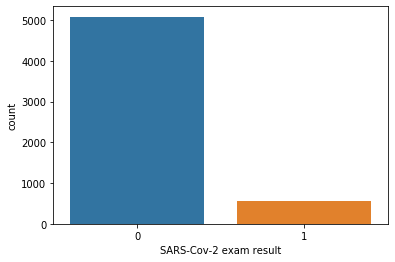

In [22]:
#univarite analysis
sns.countplot(df['SARS-Cov-2 exam result'])
plt.show()

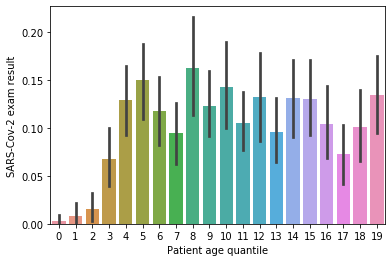

In [23]:
#bivariate analysis
sns.barplot(x='Patient age quantile',y='SARS-Cov-2 exam result',data=df) 
plt.show()

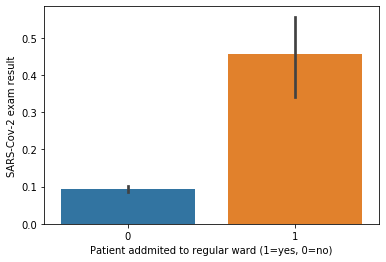

In [24]:
sns.barplot(x='Patient addmited to regular ward (1=yes, 0=no)',y='SARS-Cov-2 exam result',data=df) 
plt.show()

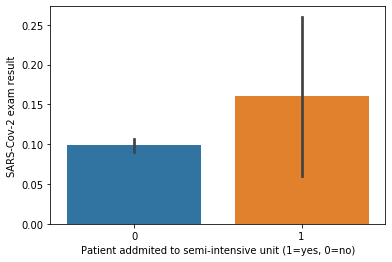

In [25]:
sns.barplot(x='Patient addmited to semi-intensive unit (1=yes, 0=no)',y='SARS-Cov-2 exam result',data=df) 
plt.show()

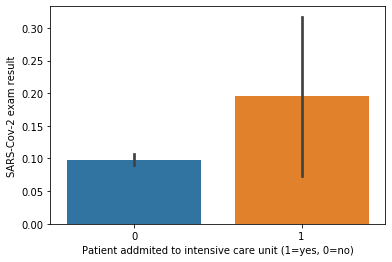

In [26]:
sns.barplot(x='Patient addmited to intensive care unit (1=yes, 0=no)',y='SARS-Cov-2 exam result',data=df) 
plt.show()

In [28]:
#correlation matrix
df.corr()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,...,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
Patient ID,1.000000,-0.014136,-0.018664,0.003748,-0.004803,0.000162,-0.006583,-0.008980,0.001514,-0.010793,...,0.018114,0.005291,-0.019136,0.003382,-0.028136,-0.011102,0.012767,-0.020327,0.005341,NaN
Patient age quantile,-0.014136,1.000000,0.075244,0.046166,0.015736,-0.035772,0.122152,0.003117,0.060413,-0.013365,...,-0.022472,-0.003946,0.068541,0.048736,-0.003178,0.002076,0.040195,0.017332,0.022477,NaN
SARS-Cov-2 exam result,-0.018664,0.075244,1.000000,0.142437,0.019364,0.027586,0.031941,0.018736,0.023604,0.007639,...,0.013955,0.013237,0.015915,0.019251,-0.001640,0.012479,0.044030,0.006236,0.016517,NaN
"Patient addmited to regular ward (1=yes, 0=no)",0.003748,0.046166,0.142437,1.000000,-0.011264,-0.010192,-0.035867,0.006739,-0.011990,0.002748,...,-0.030842,0.004762,0.005725,0.006925,0.004762,0.004489,0.004292,0.002243,-0.024378,NaN
"Patient addmited to semi-intensive unit (1=yes, 0=no)",-0.004803,0.015736,0.019364,-0.011264,1.000000,-0.008087,-0.129416,0.005348,-0.021481,0.002180,...,-0.040978,0.003778,-0.034901,0.005495,0.003778,0.003562,-0.001908,0.001780,0.004714,NaN
"Patient addmited to intensive care unit (1=yes, 0=no)",0.000162,-0.035772,0.027586,-0.010192,-0.008087,1.000000,-0.188287,0.004839,-0.007925,0.001973,...,0.003604,0.003419,-0.039413,0.004972,0.003419,0.003223,-0.020574,0.001611,0.004266,NaN
Respiratory Syncytial Virus,-0.006583,0.122152,0.031941,-0.035867,-0.129416,-0.188287,1.000000,-0.005454,-0.011341,-0.002224,...,-0.004063,-0.003854,0.072736,0.026411,-0.003854,-0.003633,-0.012819,-0.001816,-0.004809,NaN
Influenza A,-0.008980,0.003117,0.018736,0.006739,0.005348,0.004839,-0.005454,1.000000,-0.006652,-0.001304,...,-0.002383,-0.002261,-0.002718,0.050964,-0.002261,-0.002131,0.136825,-0.001065,-0.002821,NaN
Influenza B,0.001514,0.060413,0.023604,-0.011990,-0.021481,-0.007925,-0.011341,-0.006652,1.000000,-0.002712,...,-0.004955,0.033579,0.026211,-0.006835,-0.004700,-0.004431,-0.003941,-0.002214,0.024841,NaN
Parainfluenza 1,-0.010793,-0.013365,0.007639,0.002748,0.002180,0.001973,-0.002224,-0.001304,-0.002712,1.000000,...,-0.000972,-0.000922,-0.001108,-0.001340,-0.000922,-0.000869,-0.003066,-0.000434,-0.001150,NaN


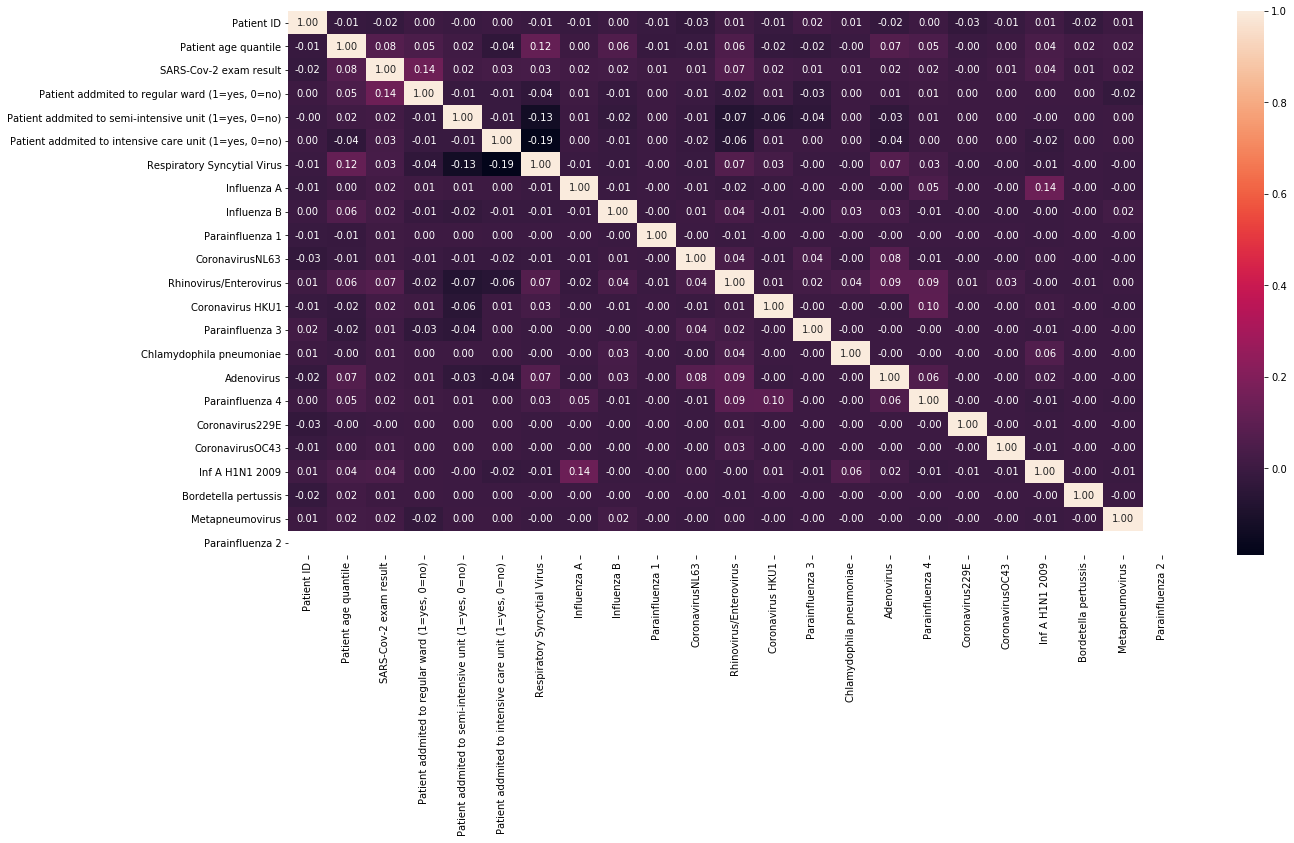

In [29]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

# Data Cleaning

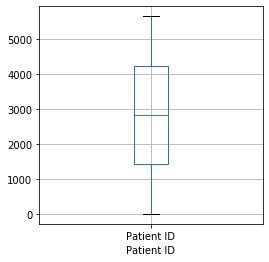

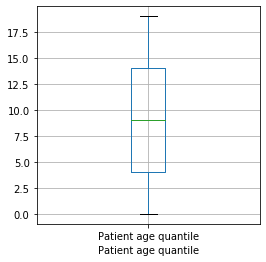

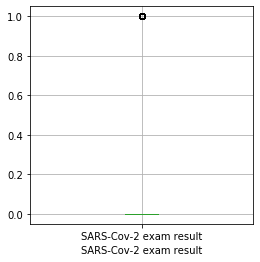

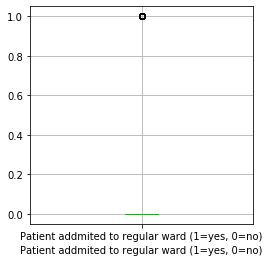

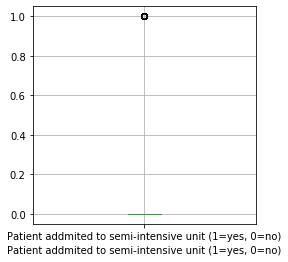

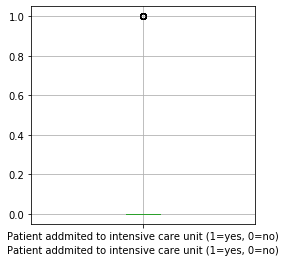

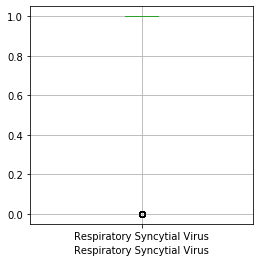

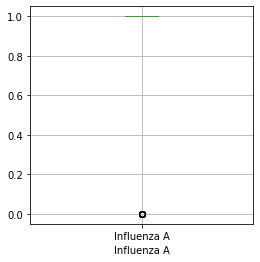

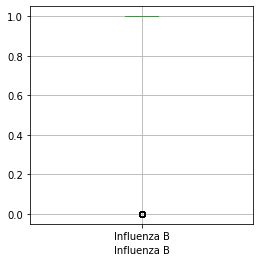

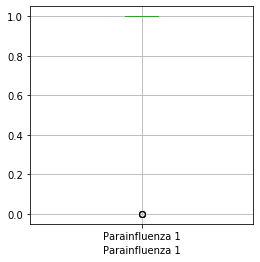

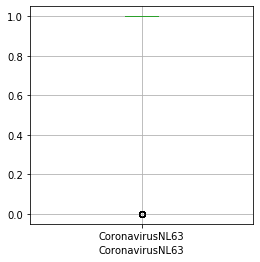

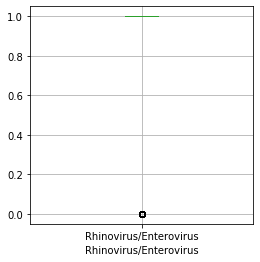

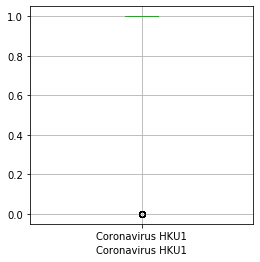

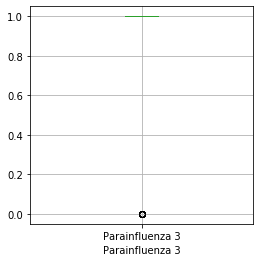

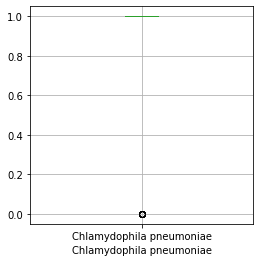

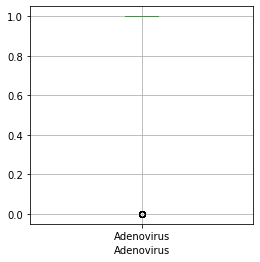

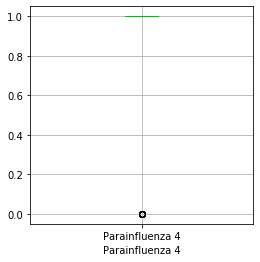

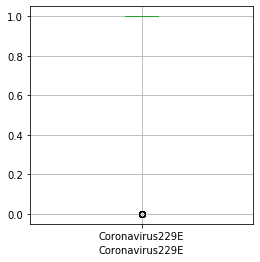

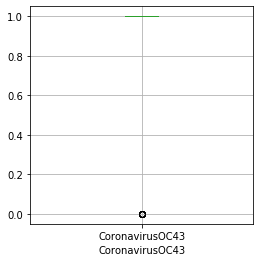

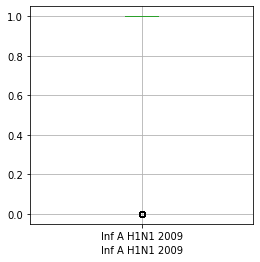

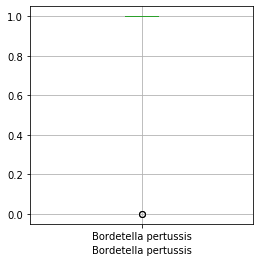

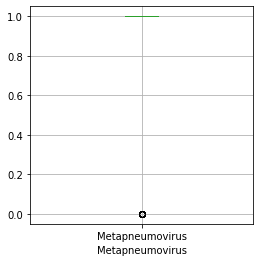

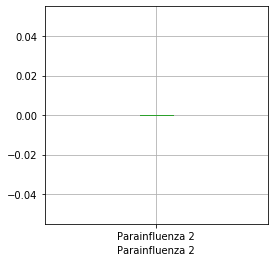

In [30]:
for i in df.columns:
        plt.figure(figsize = (4,4))
        df.boxplot(column=[i])
        plt.xlabel(i)

In [31]:
y=df["SARS-Cov-2 exam result"]
dfx=df.drop(columns=['SARS-Cov-2 exam result'], axis=1)

In [32]:
dfx.skew()

Patient ID                                                0.000000
Patient age quantile                                      0.034623
Patient addmited to regular ward (1=yes, 0=no)            8.276088
Patient addmited to semi-intensive unit (1=yes, 0=no)    10.485579
Patient addmited to intensive care unit (1=yes, 0=no)    11.607647
Respiratory Syncytial Virus                             -10.276375
Influenza A                                             -17.627362
Influenza B                                              -8.387486
Parainfluenza 1                                         -43.351272
CoronavirusNL63                                         -11.067762
Rhinovirus/Enterovirus                                   -3.459793
Coronavirus HKU1                                        -16.713828
Parainfluenza 3                                         -23.700218
Chlamydophila pneumoniae                                -24.988890
Adenovirus                                              -20.76

In [33]:
# handling skewness
from scipy.stats import boxcox
for col in dfx.columns:
    if dfx.skew().loc[col]>0.55:
        dfx[col]=np.log1p(dfx[col])

In [34]:
dfx.skew()

Patient ID                                                0.000000
Patient age quantile                                      0.034623
Patient addmited to regular ward (1=yes, 0=no)            8.276088
Patient addmited to semi-intensive unit (1=yes, 0=no)    10.485579
Patient addmited to intensive care unit (1=yes, 0=no)    11.607647
Respiratory Syncytial Virus                             -10.276375
Influenza A                                             -17.627362
Influenza B                                              -8.387486
Parainfluenza 1                                         -43.351272
CoronavirusNL63                                         -11.067762
Rhinovirus/Enterovirus                                   -3.459793
Coronavirus HKU1                                        -16.713828
Parainfluenza 3                                         -23.700218
Chlamydophila pneumoniae                                -24.988890
Adenovirus                                              -20.76

In [35]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
x=ss.fit_transform(dfx)
x=pd.DataFrame(x,columns=dfx.columns)
x.head()

,Patient ID,Patient age quantile,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,...,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
0,-0.757082,0.637244,-0.119146,-0.094542,-0.085542,0.096431,0.056564,0.117607,0.023061,0.08965,...,0.04213,0.039964,0.048048,0.058119,0.039964,0.037676,0.13293,0.018828,0.049867,0.0
1,-1.454935,1.329598,-0.119146,-0.094542,-0.085542,0.096431,0.056564,0.117607,0.023061,0.08965,...,0.04213,0.039964,0.048048,0.058119,0.039964,0.037676,0.13293,0.018828,0.049867,0.0
2,0.520168,-0.228198,-0.119146,-0.094542,-0.085542,0.096431,0.056564,0.117607,0.023061,0.08965,...,0.04213,0.039964,0.048048,0.058119,0.039964,0.037676,0.13293,0.018828,0.049867,0.0
3,1.617583,-0.747464,-0.119146,-0.094542,-0.085542,0.096431,0.056564,0.117607,0.023061,0.08965,...,0.04213,0.039964,0.048048,0.058119,0.039964,0.037676,0.13293,0.018828,0.049867,0.0
4,1.240730,0.983421,-0.119146,-0.094542,-0.085542,0.096431,0.056564,0.117607,0.023061,0.08965,...,0.04213,0.039964,0.048048,0.058119,0.039964,0.037676,0.13293,0.018828,0.049867,0.0


# Model building

In [36]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.33,random_state=42)

In [37]:
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(3781, 22) (1863, 22)
(3781,) (1863,)


In [38]:
maxrscore=0
for r_state in range(42,100):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.33,random_state=r_state)
    reg=linear_model.LinearRegression()
    reg.fit(x_train,y_train)
    y_pred= reg.predict(x_test)
    r2s=r2_score(y_test,y_pred)
    if r2s > maxrscore:
        maxrscore=r2s
        fr_state=r_state
print("max r2 score corresponding to ",fr_state," is ",maxrscore)

max r2 score corresponding to  93  is  0.054717471637222515


In [39]:
#GRID SEARCHCV
parameter = {'kernel':('linear', 'rbf','poly'), 'C':[1, 10]}
svc = SVC()
grid = GridSearchCV( estimator=SVC(), param_grid = parameter)
grid.fit(x, y)
print(grid)
#print(grid.best_score)
print(grid.best_estimator_.kernel)
print(grid.best_params_)
s=grid.best_estimator_.kernel

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf', 'poly')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
rbf
{'C': 10, 'kernel': 'rbf'}


In [40]:
#GRID SEARCHCV
parameter = {'n_neighbors':(3,5,7,9,11), 'weights':['uniform','distance']}
knn = KNeighborsClassifier()
grid = GridSearchCV( estimator=knn, param_grid = parameter)
grid.fit(x, y)
print(grid)
#print(grid.best_score)
print(grid.best_estimator_.n_neighbors)
print(grid.best_estimator_.weights)
print(grid.best_params_)
k=grid.best_estimator_.n_neighbors
w=grid.best_estimator_.weights

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': (3, 5, 7, 9, 11),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
9
uniform
{'n_neighbors': 9, 'weights': 'uniform'}


In [41]:
KNN=KNeighborsClassifier(n_neighbors=k,weights=w)
SV=SVC(kernel=s)
LR=LogisticRegression()
DT=DecisionTreeClassifier(random_state=fr_state)
GNB=GaussianNB()
XGBC=GradientBoostingClassifier()
RFC=RandomForestClassifier()

In [42]:
models = []
models.append(('KNeighborsClassifier', KNN))
models.append(('SVC', SV))
models.append(('LogisticRegression', LR))
models.append(('DecisionTreeClassifier', DT))
models.append(('GaussianNB', GNB))
models.append(('RandomForestClassifier', RFC))
models.append(('GradientBoostingClassifier', XGBC))

*********************** KNeighborsClassifier ***********************


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')


Accuracy_score =  0.8985507246376812


Cross_Val_Score =  0.9011338103307601


roc_auc_score =  0.5130285884455033


classification_report
               precision    recall  f1-score   support

           0       0.90      0.99      0.95      1679
           1       0.35      0.03      0.06       184

    accuracy                           0.90      1863
   macro avg       0.63      0.51      0.50      1863
weighted avg       0.85      0.90      0.86      1863



[[1668   11]
 [ 178    6]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)



*********************** SVC ***********************


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel=

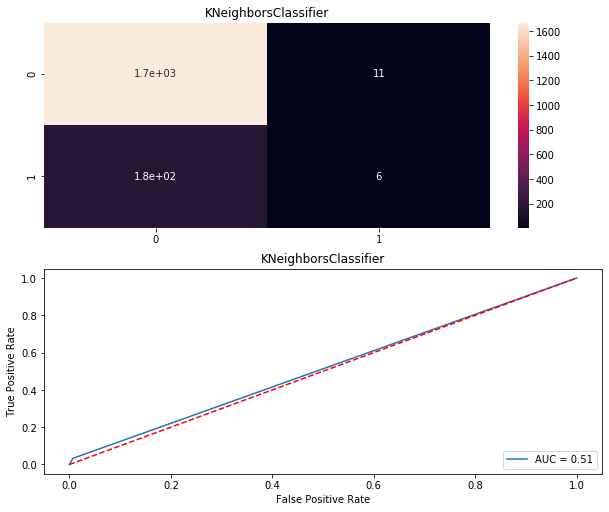

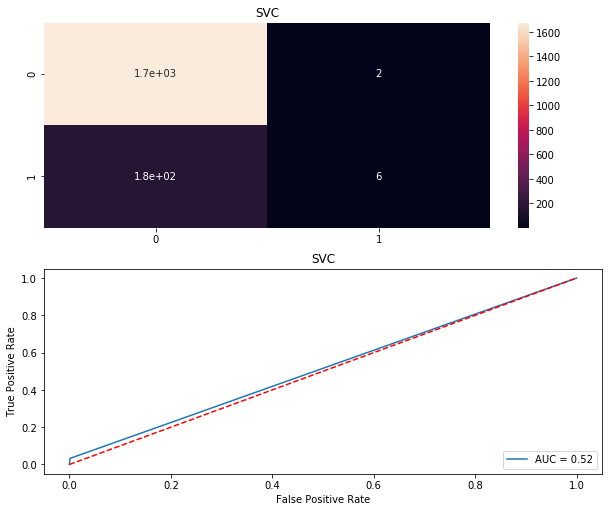

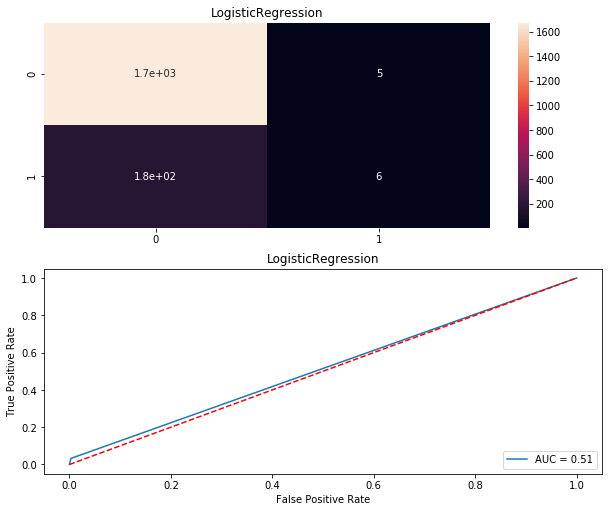

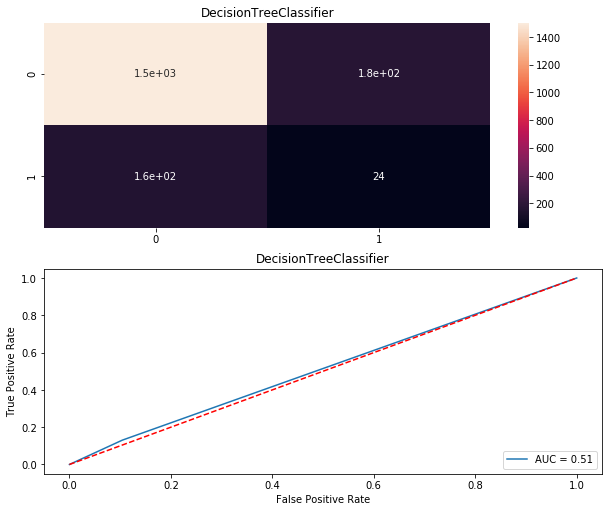

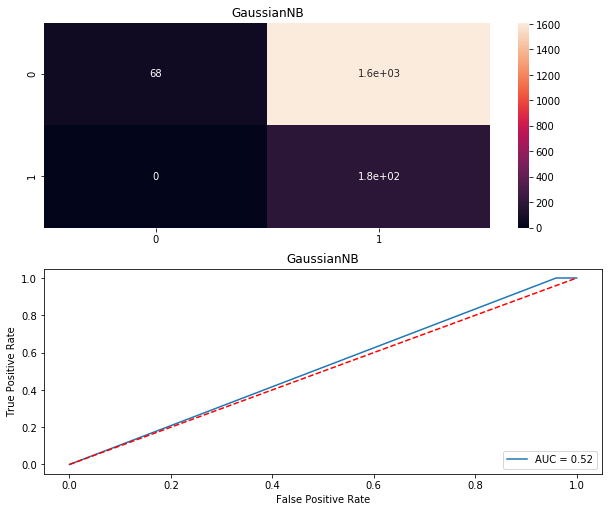

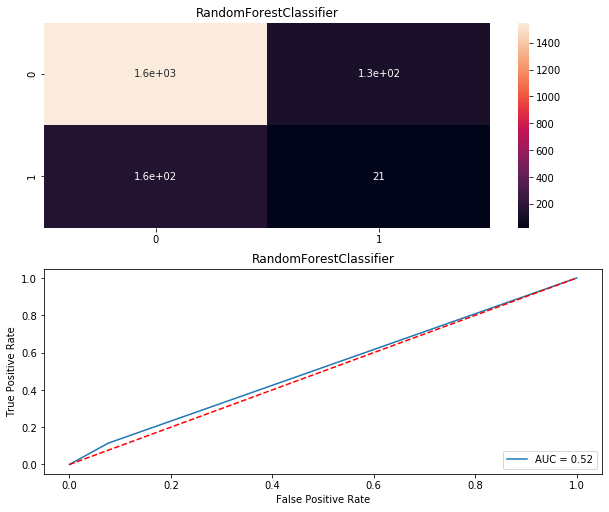

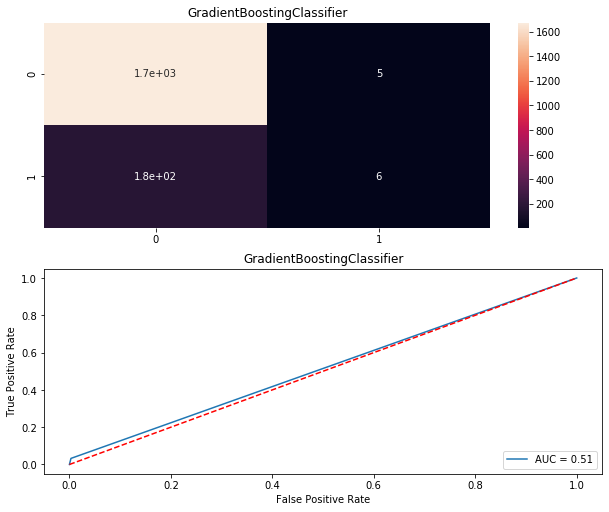

In [43]:
Model = []
score = []
cvs=[]
rocscore=[]
for name,model in models:
    print('***********************',name,'***********************')
    print('\n')
    Model.append(name)
    model.fit(x_train,y_train)
    print(model)
    pre=model.predict(x_test)
    print('\n')
    AS=accuracy_score(y_test,pre)
    print('Accuracy_score = ',AS)
    score.append(AS*100)
    print('\n')
    sc = cross_val_score(model, x, y, cv=10, scoring='accuracy').mean()
    print('Cross_Val_Score = ',sc)
    cvs.append(sc*100)
    print('\n')
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,pre)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ('roc_auc_score = ',roc_auc)
    rocscore.append(roc_auc*100)
    print('\n')
    print('classification_report\n',classification_report(y_test,pre))
    print('\n')
    cm=confusion_matrix(y_test,pre)
    print(cm)
    print('\n')
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    print(sns.heatmap(cm,annot=True))
    plt.subplot(912)
    plt.title(name)
    plt.plot(false_positive_rate, true_positive_rate, label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    print('\n\n')

In [44]:
result = pd.DataFrame({'Model': Model, 'Accuracy_score': score ,'Cross_val_score':cvs,'Rou_auc_score':rocscore})
result

,Model,Accuracy_score,Cross_val_score,Rou_auc_score
0,KNeighborsClassifier,89.855072,90.113381,51.302859
1,SVC,90.338164,90.414643,51.570876
2,LogisticRegression,90.177134,90.148748,51.481537
3,DecisionTreeClassifier,82.018250,82.547511,51.310304
4,GaussianNB,13.526570,14.367288,52.025015
5,RandomForestClassifier,84.380032,84.017825,51.894729
6,GradientBoostingClassifier,90.177134,90.077857,51.481537


# Saving the best model

In [45]:
from sklearn.externals import joblib

In [46]:
joblib.dump(SV,'brazilcovidconfirm.pkl')

['brazilcovidconfirm.pkl']

In [47]:
model=joblib.load('brazilcovidconfirm.pkl')

In [48]:
model.predict(x_test.head())

array([0, 0, 1, 0, 0], dtype=int8)